$\textbf{TEXT CLASSIFICATION WITH TORCHTEXT}$

In [1]:
# https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

import torch
import torchtext  # conda install -c pytorch torchtext
from torchtext.datasets import text_classification

import torch.nn as nn
import torch.nn.functional as F

import os

In [ ]:
NGRAMS = 2

if not os.path.isdir('data'):
    os.mkdir('data')
train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](
    root='data', ngrams=NGRAMS, vocab=None)
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

120000lines [00:04, 24254.26lines/s]
96196lines [00:07, 13267.08lines/s]

$\textbf{Define the model}$

The model is composed of the EmbeddingBag layer and the linear layer (see the figure below). `nn.EmbeddingBag` computes the mean value of a “bag” of embeddings. The text entries here have different lengths. `nn.EmbeddingBag` requires no padding here since the text lengths are saved in offsets.

Additionally, since `nn.EmbeddingBag` accumulates the average across the embeddings on the fly, `nn.EmbeddingBag` can enhance the performance and memory efficiency to process a sequence of tensors.

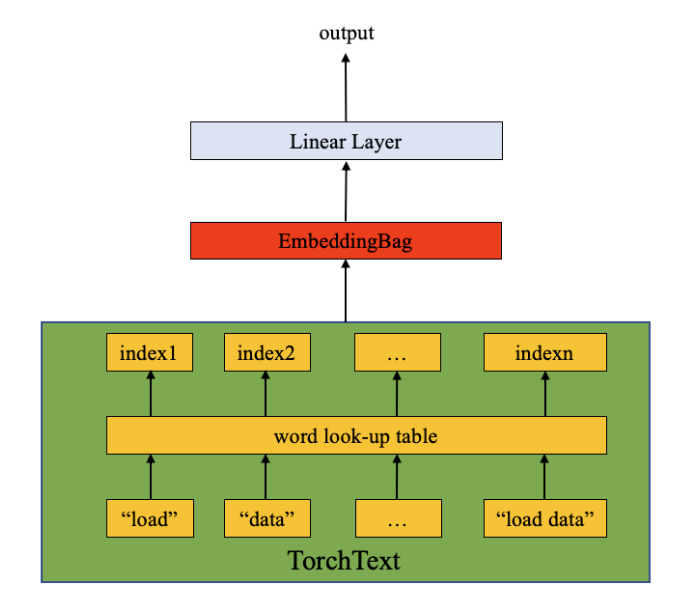

In [5]:
# Define my neural network model
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [6]:
# The vocab size is equal to the length of vocab (including single word and ngrams).
# The number of classes is equal to the number of labels, which is four in AG_NEWS case.

VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

$\textbf{Functions used to generate batch}$

Since the text entries have different lengths, a custom function `generate_batch()` is used to generate data batches and offsets. The function is passed to `collate_fn` in `torch.utils.data.DataLoader`. The input to `collate_fn` is a list of tensors with the size of `batch_size`, and the collate_fn function packs them into a mini-batch. Pay attention here and make sure that `collate_fn` is declared as a top level def. This ensures that the function is available in each worker.

The text entries in the original data batch input are packed into a list and concatenated as a single tensor as the input of `nn.EmbeddingBag`. The offsets is a tensor of delimiters to represent the beginning index of the individual sequence in the text tensor. Label is a tensor saving the labels of individual text entries.

In [7]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [8]:
from torch.utils.data import DataLoader

def train_func(sub_train_, optimizer, scheduler=None):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
    
    if scheduler != None:
        # Adjust the learning rate
        scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

$\textbf{Split the dataset and run the model}$

Since the original AG_NEWS has no valid dataset, we split the training dataset into train/valid sets with a split ratio of 0.95 (train) and 0.05 (valid). Here we use `torch.utils.data.dataset.random_split` function in PyTorch core library.

`CrossEntropyLoss` criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in a single class. It is useful when training a classification problem with C classes. SGD implements stochastic gradient descent method as optimizer. The initial learning rate is set to 4.0. `StepLR` is used here to adjust the learning rate through epochs.

In [9]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 5
min_valid_loss = float('inf')

optimizers = {}
schedulers = {}

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizers['SGD'] = torch.optim.SGD(model.parameters(), lr=4.0)
optimizers['AdamW'] = torch.optim.AdamW(model.parameters(), lr=4.0, amsgrad=True)

optimizer = 'SGD'

#scheduler['StepLR'] = torch.optim.lr_scheduler.StepLR(optimizers[optimizer], 1, gamma=0.9)

#scheduler = 'StepLR'

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_, optimizers[optimizer])
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

Epoch: 1  | time in 0 minutes, 7 seconds
	Loss: 0.0263(train)	|	Acc: 84.7%(train)
	Loss: 0.0002(valid)	|	Acc: 90.2%(valid)
Epoch: 2  | time in 0 minutes, 7 seconds
	Loss: 0.0122(train)	|	Acc: 93.5%(train)
	Loss: 0.0002(valid)	|	Acc: 90.9%(valid)
Epoch: 3  | time in 0 minutes, 8 seconds
	Loss: 0.0072(train)	|	Acc: 96.1%(train)
	Loss: 0.0003(valid)	|	Acc: 90.1%(valid)
Epoch: 4  | time in 0 minutes, 7 seconds
	Loss: 0.0042(train)	|	Acc: 97.8%(train)
	Loss: 0.0004(valid)	|	Acc: 90.3%(valid)
Epoch: 5  | time in 0 minutes, 8 seconds
	Loss: 0.0027(train)	|	Acc: 98.7%(train)
	Loss: 0.0004(valid)	|	Acc: 91.0%(valid)


$\textbf{Evaluate the model with test dataset}$

In [10]:
print(f'Checking the results of test dataset with {optimizer}...')
test_loss, test_acc = test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset with SGD...
	Loss: 0.0003(test)	|	Acc: 90.4%(test)


In [23]:
print(f'Checking the results of test dataset with {optimizer}...')
test_loss, test_acc = test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0002(test)	|	Acc: 88.9%(test)


In [11]:
# Test on a random news
# Use the best model so far and test a golf news. 
# The label information is available here.
# https://pytorch.org/text/datasets.html?highlight=ag_news#torchtext.datasets.AG_NEWS

import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

ag_news_label = {1 : "World",
                 2 : "Sports",
                 3 : "Business",
                 4 : "Sci/Tec"}

def predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

vocab = train_dataset.get_vocab()
model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, model, vocab, 2)])

This is a Sports news
